In [31]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.layers import Dense, Dropout, Embedding, Input, Concatenate, MultiHeadAttention


In [32]:
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

class Encodeur(tf.keras.layers.Layer):
    def __init__(self, n_layers, d_model, num_heads, middle_units,
                 max_seq_len, epsilon=1e-6, dropout_rate=0.1, training=False, **kwargs):
        super(Encodeur, self).__init__(**kwargs)
        self.n_layers = n_layers

        self.embedding_position = EncodagePosition(sequence_len=max_seq_len, embedding_dim=d_model)
        self.couche_encode = [CoucheEncodeur(d_model=d_model, num_heads=num_heads,max_seq_len=max_seq_len,
                                            middle_units=middle_units,
                                            epsilon=epsilon, dropout_rate=dropout_rate,
                                            training=training)
                             for _ in range(n_layers)]

    def call(self, inputs, **kwargs):
        emb, masque = inputs
        emb = self.embedding_position(emb)
        for i in range(self.n_layers):
            emb = self.couche_encode[i](emb, masque)

        return emb


# Couche d'encodage
class CoucheEncodeur(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, max_seq_len, middle_units, epsilon=1e-6, dropout_rate=0.1, training=False, **kwargs):
        super(CoucheEncodeur, self).__init__(**kwargs)

        self.mha = AttentionMultiTete(num_heads)
        # self.ffn = reseau_transformation_point_a_point(d_model + max_seq_len, middle_units) ## Erreur de Dimension
        self.ffn = reseau_transformation_point_a_point(d_model, middle_units)

        self.layernorm1 = NormalisationCouche()
        self.layernorm2 = NormalisationCouche()

        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

        self.training = training

    def call(self, inputs, masque, **kwargs):
        # Réseau d'attention multi-tête
        sortie_att = self.mha([inputs, inputs, inputs, masque])
        sortie_att = self.dropout1(sortie_att, training=self.training)
        out1 = self.layernorm1(inputs + sortie_att)

        # Réseau de transformation point à point
        sortie_ffn = self.ffn(out1)
        sortie_ffn = self.dropout2(sortie_ffn, training=self.training)
        out2 = self.layernorm2(out1 + sortie_ffn)  # Problème de dimension ici

        return out2

# Normalisation de couche
class NormalisationCouche(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-6, **kwargs):
        self.eps = epsilon
        super(NormalisationCouche, self).__init__(**kwargs)

    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=tf.ones_initializer(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=tf.zeros_initializer(), trainable=True)
        super(NormalisationCouche, self).build(input_shape)

    def call(self, x):
        moyenne = tf.keras.backend.mean(x, axis=-1, keepdims=True)
        ecart_type = tf.keras.backend.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - moyenne) / (ecart_type + self.eps) + self.beta

    def compute_output_shape(self, input_shape):
        return input_shape


# Réseau de transformation point à point
def reseau_transformation_point_a_point(numUnits, middle_units):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(middle_units, activation='relu'),
        tf.keras.layers.Dense(numUnits, activation='relu')])


# Attention à produit scalaire équilibrée
def attention_produit_scalaire_equilibre(q, k, v, masque):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dim_k = tf.cast(tf.shape(k)[-1], tf.float32)
    attention_logits_mis_a_echelle = matmul_qk / tf.math.sqrt(dim_k)
    if masque is not None:
        attention_logits_mis_a_echelle += (masque * -1e9)

    poids_attention = tf.nn.softmax(attention_logits_mis_a_echelle, axis=-1)
    sortie = tf.matmul(poids_attention, v)
    return sortie


# Construction de la couche d'attention multi-tête
class AttentionMultiTete(tf.keras.layers.Layer):
    def __init__(self, num_heads, **kwargs):
        super(AttentionMultiTete, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention_produit_scalaire = attention_produit_scalaire_equilibre

    def separation_tetes(self, x, batch_size, profondeur):
        # Séparation des têtes, déplace la dimension du nombre de têtes avant la séquence
        x = tf.reshape(x, (batch_size, -1, self.num_heads, profondeur))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs, **kwargs):
        q, k, v, masque = inputs
        batch_size = tf.shape(q)[0]
        numUnits = q.get_shape().as_list()[-1]
        profondeur = numUnits // self.num_heads

        # Avant la séparation des têtes, réseau avant la séparation
        wq = tf.keras.layers.Dense(numUnits)
        wk = tf.keras.layers.Dense(numUnits)
        wv = tf.keras.layers.Dense(numUnits)
        q = wq(q)
        k = wk(k)
        v = wv(v)

        # Séparation des têtes
        q = self.separation_tetes(q, batch_size, profondeur)
        k = self.separation_tetes(k, batch_size, profondeur)
        v = self.separation_tetes(v, batch_size, profondeur)

        # À travers la couche d'attention à produit scalaire équilibré
        attention_mise_a_echelle = self.attention_produit_scalaire(q, k, v, masque)

        # Déplacement de la dimension "têtes multiples"
        attention_mise_a_echelle = tf.transpose(attention_mise_a_echelle, [0, 2, 1, 3])

        # Fusion de la dimension "têtes multiples"
        attention_concatenee = tf.reshape(attention_mise_a_echelle, (batch_size, -1, numUnits))

        # Couche entièrement connectée
        dense = tf.keras.layers.Dense(numUnits)
        sortie = dense(attention_concatenee)

        return sortie

# Fonction de masquage
def masque_remplissage(seq):
    # Obtenir les éléments de remplissage (paddings) égaux à 0
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # Élargir les dimensions pour la matrice d'attention
    return seq[:, np.newaxis, np.newaxis, :]  # (batch_size, 1, 1, seq_len)


# Encodage des positions
class EncodagePosition(tf.keras.layers.Layer):
    def __init__(self, sequence_len=None, embedding_dim=None, **kwargs):
        self.sequence_len = sequence_len
        self.embedding_dim = embedding_dim
        super(EncodagePosition, self).__init__(**kwargs)

    def call(self, inputs):
        if self.embedding_dim is None:
            self.embedding_dim = int(inputs.shape[-1])

        encodage_position = np.array([
            [pos / np.power(10000, 2. * i / self.embedding_dim) for i in range(self.embedding_dim)]
            for pos in range(self.sequence_len)])

        encodage_position[:, 0::2] = np.sin(encodage_position[:, 0::2])  # dim 2i
        encodage_position[:, 1::2] = np.cos(encodage_position[:, 1::2])  # dim 2i+1

        encodage_position = tf.cast(encodage_position, dtype=tf.float32)

        return encodage_position + inputs

    def compute_output_shape(self, input_shape):
        return input_shape



In [33]:
################ Bon Code ###############
#### charger et lire un dataset [.zip] sur coolab ####

import zipfile
import os
import pandas as pd

import shutil

# # Chemins vers les fichiers zip quand je suis sur google Coolab

chemin_zip = "Total_CSVs.zip"


# Fonction pour extraire les fichiers zip
def extraire_zip(chemin_zip):
    with zipfile.ZipFile(chemin_zip, 'r') as zip_ref:
        zip_ref.extractall("extraction_temp")  # Extraire les fichiers zip dans un répertoire temporaire

# Fonction pour charger les fichiers CSV d'un type spécifique (stateful ou stateless)
def charger_concatener_donnees(sous_dossier, prefixe):
    # Lister tous les fichiers CSV dans le sous-dossier
    fichiers_csv = [f for f in os.listdir(f"extraction_temp/{sous_dossier}") if f.startswith(prefixe) and f.endswith('.csv')]
    # Lire chaque fichier CSV et le stocker dans une liste de DataFrames
    dataframes = [pd.read_csv(f"extraction_temp/{sous_dossier}/{f}") for f in fichiers_csv]
    # Concaténer les DataFrames en un seul
    return pd.concat(dataframes, ignore_index=True)

# Extraire les fichiers zip
extraire_zip(chemin_zip)

benign = charger_concatener_donnees("", "l2-benign")
malicious = charger_concatener_donnees("", "l2-malicious")

# Supprimer le répertoire temporaire après avoir terminé

# Vérifier si le répertoire temporaire existe
if os.path.exists("extraction_temp"):
    # Supprimer le répertoire temporaire et son contenu
    shutil.rmtree("extraction_temp")


# Maintenant, vous avez vos données prêtes à être utilisées


In [34]:
print(benign.shape)
print("\n")
print(malicious.shape)
print("\n")


data = pd.concat([benign, malicious], ignore_index=True)
# balanced_benign = benin_data.sample(23716, random_state=42)
# balanced_samples_malicioux = balanced_samples_malicioux.sample(22929, random_state=42)
print(data['Label'].value_counts())
print(data.shape)




(19807, 35)


(249836, 35)


Label
Malicious    249836
Benign        19807
Name: count, dtype: int64
(269643, 35)


In [35]:
print(data.dtypes)

SourceIP                                   object
DestinationIP                              object
SourcePort                                  int64
DestinationPort                             int64
TimeStamp                                  object
Duration                                  float64
FlowBytesSent                               int64
FlowSentRate                              float64
FlowBytesReceived                           int64
FlowReceivedRate                          float64
PacketLengthVariance                      float64
PacketLengthStandardDeviation             float64
PacketLengthMean                          float64
PacketLengthMedian                        float64
PacketLengthMode                            int64
PacketLengthSkewFromMedian                float64
PacketLengthSkewFromMode                  float64
PacketLengthCoefficientofVariation        float64
PacketTimeVariance                        float64
PacketTimeStandardDeviation               float64


In [36]:
num = data.select_dtypes(include=["int","float"])

cat = data.select_dtypes(include=['object'])

bol = data.select_dtypes(include=['bool'])

In [37]:
print(num.columns)
print("\n")
print(cat.columns)
print("\n")
print(bol.columns)


Index(['SourcePort', 'DestinationPort', 'Duration', 'FlowBytesSent',
       'FlowSentRate', 'FlowBytesReceived', 'FlowReceivedRate',
       'PacketLengthVariance', 'PacketLengthStandardDeviation',
       'PacketLengthMean', 'PacketLengthMedian', 'PacketLengthMode',
       'PacketLengthSkewFromMedian', 'PacketLengthSkewFromMode',
       'PacketLengthCoefficientofVariation', 'PacketTimeVariance',
       'PacketTimeStandardDeviation', 'PacketTimeMean', 'PacketTimeMedian',
       'PacketTimeMode', 'PacketTimeSkewFromMedian', 'PacketTimeSkewFromMode',
       'PacketTimeCoefficientofVariation', 'ResponseTimeTimeVariance',
       'ResponseTimeTimeStandardDeviation', 'ResponseTimeTimeMean',
       'ResponseTimeTimeMedian', 'ResponseTimeTimeMode',
       'ResponseTimeTimeSkewFromMedian', 'ResponseTimeTimeSkewFromMode',
       'ResponseTimeTimeCoefficientofVariation'],
      dtype='object')


Index(['SourceIP', 'DestinationIP', 'TimeStamp', 'Label'], dtype='object')


Index([], dtype='object')


In [38]:
num.var()

SourcePort                                3.751527e+08
DestinationPort                           3.244232e+08
Duration                                  2.074503e+03
FlowBytesSent                             3.617698e+10
FlowSentRate                              2.954580e+10
FlowBytesReceived                         3.321077e+10
FlowReceivedRate                          1.019186e+10
PacketLengthVariance                      1.976722e+10
PacketLengthStandardDeviation             3.991369e+04
PacketLengthMean                          5.880786e+03
PacketLengthMedian                        1.788516e+03
PacketLengthMode                          7.187903e+01
PacketLengthSkewFromMedian                2.660350e+00
PacketLengthSkewFromMode                  2.079310e+00
PacketLengthCoefficientofVariation        4.221766e-01
PacketTimeVariance                        2.738572e+05
PacketTimeStandardDeviation               1.557554e+02
PacketTimeMean                            5.872027e+02
PacketTime

In [39]:

X_numerical = data[['FlowBytesSent','FlowBytesReceived','PacketLengthVariance','PacketTimeSkewFromMode','PacketTimeCoefficientofVariation','PacketTimeMean','ResponseTimeTimeMean','ResponseTimeTimeCoefficientofVariation']]
X_categorical = data[['SourceIP','DestinationIP']]
y = data['Label']

In [40]:


print(X_numerical.shape)
print(X_categorical.shape)
print(y.info())

(269643, 8)
(269643, 2)
<class 'pandas.core.series.Series'>
RangeIndex: 269643 entries, 0 to 269642
Series name: Label
Non-Null Count   Dtype 
--------------   ----- 
269643 non-null  object
dtypes: object(1)
memory usage: 2.1+ MB
None


In [41]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.impute import SimpleImputer


#prepocessing des features numeriques soit  avec le  LabelEncoder soit le MinMaxScaler()


# Imputer les valeurs manquantes pour les caractéristiques numériques
numerical_imputer = SimpleImputer(strategy='mean')

numeric_features = pd.DataFrame(numerical_imputer.fit_transform(X_numerical), columns=X_numerical.columns)

# Création d'un scaler
scaler = MinMaxScaler()

# Ajustement du scaler aux données
scaler.fit(numeric_features)

# Transformation des fonctionnalités numériques
scaled_numeric_features = scaler.transform(numeric_features)

# Apres transformation Création d' un DataFrame à partir des valeurs transformées

scaled_df = pd.DataFrame(scaled_numeric_features, columns=numeric_features.columns)

# Afficher le DataFrame avec les valeurs transformées
print("Après transformation")
print(scaled_df)

total_size = scaled_df.shape

print("Taille totale des caracteristiques numeriques apres concatenations :", total_size)

Après transformation
        FlowBytesSent  FlowBytesReceived  PacketLengthVariance   
0            0.007767           0.008463              0.004736  \
1            0.011699           0.013108              0.006627   
2            0.004832           0.004951              0.004626   
3            0.007727           0.009032              0.005386   
4            0.010428           0.009945              0.005103   
...               ...                ...                   ...   
269638       0.009821           0.005966              0.005057   
269639       0.009814           0.005962              0.005159   
269640       0.009825           0.005971              0.005480   
269641       0.009635           0.005958              0.007235   
269642       0.002927           0.001798              0.005138   

        PacketTimeSkewFromMode  PacketTimeCoefficientofVariation   
0                     0.508901                          0.238000  \
1                     0.469270                    

In [42]:
features_categoriques = X_categorical.columns.tolist()
print(features_categoriques)

['SourceIP', 'DestinationIP']


In [43]:
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd


# Imputer les valeurs manquantes pour les caractéristiques catégorielles

categorical_imputer = SimpleImputer(strategy='most_frequent')
categorical_imputed = pd.DataFrame(categorical_imputer.fit_transform(X_categorical),columns=X_categorical.columns)

# Créer une copie du DataFrame pour éviter SettingWithCopyWarning
X_copy = categorical_imputed.copy()


# Appliquer une tokenisation à chaque colonne catégorielle
for feature in features_categoriques:
    X_copy[feature] = X_copy[feature].astype(str)

#Avec le separator les donnee ne sont pas bien combinée il y'a  les tokens vide et la longueur max c'est 1 d'ou c'est pas bon

X_copy['combined_text'] = X_copy[features_categoriques].apply(lambda row: ' '.join(row), axis=1)

#Avec le separator les donnee ne sont pas bien combinée il y'a  les tokens vide et la longueur max c'est 1 d'ou c'est pas bon

tokenizer = Tokenizer(num_words=10, filters=' ', split=' ')
tokenizer.fit_on_texts(X_copy['combined_text'])
tokens = tokenizer.texts_to_sequences(X_copy['combined_text'])

# Calcul de la longueur maximale du vecteur
max_sequence_length = max(len(seq) for seq in tokens)

# # Ajout des colonnes tokenisées au DataFrame
# for i in range(1, max_sequence_length+1):
#     X_copy[f'token_{i}'] = [seq[i - 1] if len(seq) >= i else 0 for seq in tokens]

# # Suppression des colonnes originales et la colonne temporaire 'combined_text'
# X_copy.drop(columns=features_categoriques + ['combined_text'], inplace=True)

# # Afficher les tokens et les longueurs de séquence
# print("Tokens:")

# print(tokens[0])

print(tokens)

print("\nLongueurs de séquence:")
print([len(seq) for seq in tokens])

#je garde les les sequences

seq_l = [len(seq) for seq in tokens]

# Affichage de la longueur maximale
print(f"Longueur maximale du vecteur : {max_sequence_length}")


[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [], 

In [44]:
# Calculer la taille du vocabulaire réel
vocab_size = len(tokenizer.word_index) + 1  # Ajoutez 1 pour tenir compte du padding

# Afficher la taille du vocabulaire
print("Taille réelle du vocabulaire:", vocab_size)

Taille réelle du vocabulaire: 22


In [45]:
print(max_sequence_length)


2


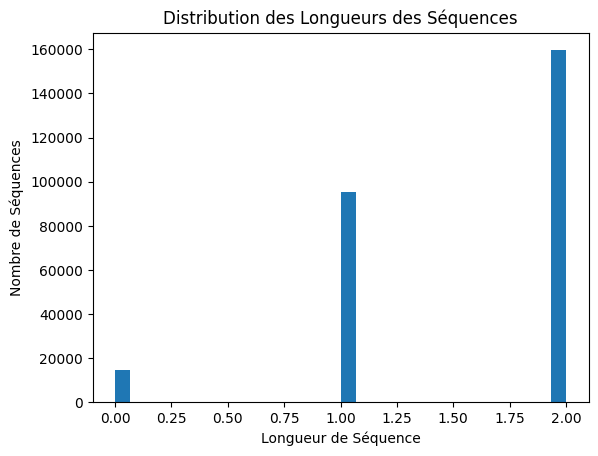

In [17]:
############ affichage longueur  max "balanced categorical feature"
seq_lenght = seq_l


mean_length = np.mean(seq_lenght)
max_length = np.max(seq_lenght)
min_length = np.min(seq_lenght)
std_dev = np.std(seq_lenght)

# Visualisation de la distribution des longueurs des séquences
import matplotlib.pyplot as plt
plt.hist(seq_lenght, bins=30)
plt.xlabel('Longueur de Séquence')
plt.ylabel('Nombre de Séquences')
plt.title('Distribution des Longueurs des Séquences')
plt.show()

In [19]:
# Hyperparamètres et dimensions des données*
taille_num_features = scaled_df.shape[1]
taille_text_features = max_sequence_length   # je donne la taille max parmi les longueur des sequences
embedding_dim = 256  ## sa dimension ne doit pas depasser la valeur du [d_model dans l'encodeur]

vocab_size = 2000

In [20]:
from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, concatenate, Dropout
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow as tf


# Entrées

############## Balanced Model ####################

input_num = tf.keras.layers.Input(shape=(taille_num_features,))
input_text = tf.keras.layers.Input(shape=(taille_text_features,))


# Branches du modèle
# Branche numérique - FFN

num_branch = tf.keras.layers.Dense(64, activation='relu')(input_num)
num_branch = tf.keras.layers.Dense(32, activation='relu')(num_branch)

# Branche textuelle - Embedding + Transformer (Un block)

text_branch = Embedding(vocab_size, embedding_dim, input_length=taille_text_features)(input_text)

mask_inputs = masque_remplissage(input_text)


out_seq = Encodeur(
            n_layers=4,
            d_model=256,
            num_heads=2,
            middle_units=256,
            max_seq_len=taille_text_features)([text_branch, mask_inputs])
# out_seq = GlobalAveragePooling1D()(out_seq)
out_seq = Dropout(0.3)(out_seq)

# Fusion des branches

# Fusion des branches

flattened_text_branch = tf.keras.layers.Flatten()(text_branch) # je remodelise les dimension
merged = tf.keras.layers.concatenate([num_branch, flattened_text_branch])

# Couches supplémentaires après la fusion
merged = Dropout(0.3)(merged)
merged = Dense(16, activation='relu')(merged)
output = Dense(1, activation='sigmoid')(merged)

# Création et compilation du modèle

model = Model(inputs=[input_num, input_text], outputs=output)
opt = Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           576         ['input_1[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 2, 256)       512000      ['input_2[0][0]']                
                                                                                              

In [46]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Entrées pour l'entraînement
data_num= scaled_df
data_text = pad_sequences(tokens, maxlen=max_sequence_length,padding='post')

from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Encodage de la cible en labels numériques
label_encoder = LabelEncoder()

# y = balanced_all_data_resampled['class']

y_encoded = label_encoder.fit_transform(y)

print(y_encoded.shape)
print("Classes encodées:", y_encoded)
print("Classes d'origine associées aux classes encodées:", label_encoder.classes_)

# print(y_balanced) [o=bengnin ,1=malicioux]


(269643,)
Classes encodées: [0 0 0 ... 1 1 1]
Classes d'origine associées aux classes encodées: ['Benign' 'Malicious']


In [47]:
################# Balanced and Imbalanced #########################

from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test
text_train, text_test, num_train, num_test, labels_train, labels_test = train_test_split(
    data_text, data_num, y_encoded, test_size=0.2, random_state=42
)


In [48]:
### Balanced

history = model.fit([num_train,text_train], labels_train , epochs=60, batch_size=16, validation_data=([num_test,text_test],labels_test))


Train on 215714 samples, validate on 53929 samples
Epoch 1/60
215714/215714 [==============================] - 403s 2ms/sample - loss: 0.0132 - accuracy: 0.9957 - val_loss: 0.0110 - val_accuracy: 0.9968
Epoch 2/60
215714/215714 [==============================] - 377s 2ms/sample - loss: 0.0125 - accuracy: 0.9958 - val_loss: 0.0122 - val_accuracy: 0.9955
Epoch 3/60
215714/215714 [==============================] - 362s 2ms/sample - loss: 0.0118 - accuracy: 0.9961 - val_loss: 0.0156 - val_accuracy: 0.9961
Epoch 4/60
215714/215714 [==============================] - 345s 2ms/sample - loss: 0.0117 - accuracy: 0.9961 - val_loss: 0.0129 - val_accuracy: 0.9955
Epoch 5/60
215714/215714 [==============================] - 341s 2ms/sample - loss: 0.0115 - accuracy: 0.9962 - val_loss: 0.0090 - val_accuracy: 0.9972
Epoch 6/60
215714/215714 [==============================] - 342s 2ms/sample - loss: 0.0109 - accuracy: 0.9965 - val_loss: 0.0109 - val_accuracy: 0.9966
Epoch 7/60
215714/215714 [===========

In [54]:
#on effectue les prediction sur les donnees de test

y_pred= model.predict([num_test,text_test])

# necessaire pour afficher la matrix de confusion car a besoin que la probabilité retourner par la fonction sigmoid soir saoit 0 ou 1 pour travailler dessus

y_pred= np.round(y_pred) ## c'est pour la classification binaire ici

### Evaluation

evaluation_results = model.evaluate([num_test,text_test], labels_test)

# Affichage des résultats

# print(f'Accuracy: {accuracy}, Loss: {loss}')
print("Perte sur les données de test:", evaluation_results[0])
print("Précision sur les données de test:", evaluation_results[1])


Perte sur les données de test: 0.005712374630910003
Précision sur les données de test: 0.99829406


In [50]:
from sklearn.metrics import classification_report,accuracy_score



print(y_pred)

# Convertir les indices des classes prédites en étiquettes
y_pred_classes = np.round(y_pred)

# Afficher le rapport de classification
class_report = classification_report(labels_test, y_pred_classes)
print("Balanced Rapport de classification :\n", class_report)



[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
Balanced Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3917
           1       1.00      1.00      1.00     50012

    accuracy                           1.00     53929
   macro avg       0.99      0.99      0.99     53929
weighted avg       1.00      1.00      1.00     53929



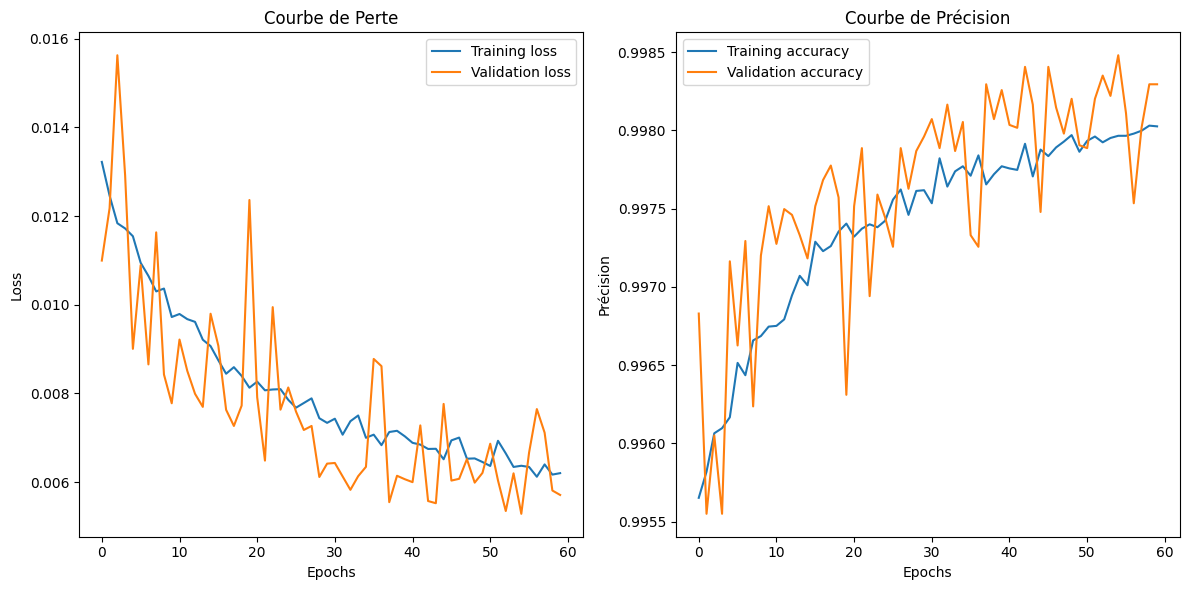

In [51]:
########## Balanced ########

import matplotlib.pyplot as plt


# Extraction des métriques d'entraînement
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Affichage des courbes de perte et d'exactitude séparément
epochs = range(1, len(loss) + 1)

# Affichage des courbes d'apprentissage et de validation
plt.figure(figsize=(12, 6))

# Plot de la perte d'entraînement et de la perte de validation
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Courbe de Perte')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Plot de la précision d'entraînement et de la précision de validation
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Courbe de Précision')
plt.xlabel('Epochs')
plt.ylabel('Précision')
plt.legend()

# Afficher les deux sous-plots
plt.tight_layout()
plt.show()

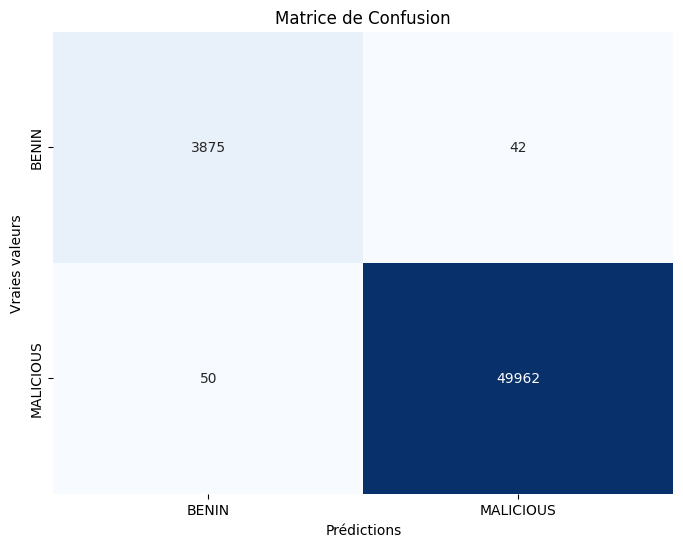

In [52]:
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, roc_curve, auc



# Matrice de confusion
conf_matrix = confusion_matrix(labels_test, y_pred_classes)


class_names = ['BENIN','MALICIOUS']

df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Afficher la matrice de confusion avec seaborn
plt.figure(figsize=(8, 6))
sn.heatmap(df_cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.show()

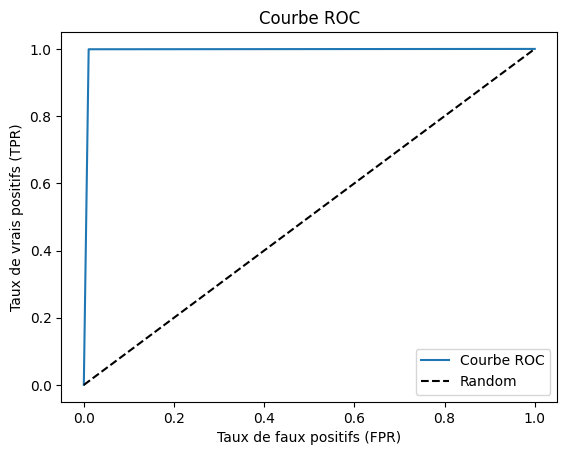

Aire sous la courbe (AUC) : 0.9941388741197901


In [53]:
#Courbe de ROC

from sklearn.metrics import roc_curve, roc_auc_score

# Calcul des taux FPR et TPR
fpr, tpr, thresholds = roc_curve(labels_test, y_pred_classes)

# Plotter la courbe ROC
plt.plot(fpr, tpr, label='Courbe ROC')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend()
plt.show()

# Calcul de l'AUC
auc = roc_auc_score(labels_test, y_pred_classes)
print('Aire sous la courbe (AUC) :', auc)
